In [1]:

import pickle
import numpy as np
import pandas as pd 
#import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
import joblib



In [2]:
demand = pd.read_csv("demand_hourly.csv")
tss = TimeSeriesSplit(n_splits=5, test_size=24*60, gap=24)
df = demand.sort_values(by=['start_time_year', 'start_time_month', 
                            'start_time_day', 'start_time_hour'])
df = df.drop(columns=['Unnamed: 0', 'duration_sec']).reset_index(drop=True)

standard_stations = pd.read_csv("stations_with_clusters.csv")
weather_data = pd.read_csv("weather_data.csv")

df = df.merge(standard_stations[['station_name', 'clusters']].rename(columns={
    "station_name":'start_station_name'}), on=["start_station_name"])

df = df[df.groupby('start_station_name')['start_station_name'].transform('size') >= 1000]

latest_trips = df.groupby('start_station_name').nth(-1)
earliest_trips = df.groupby('start_station_name').nth(0)


recently_operational_stations = latest_trips[(latest_trips['start_time_year'] == 2022) & 
                                             (latest_trips['start_time_month'] >= 8)].index

stations_operational_since_2021 = earliest_trips[(earliest_trips['start_time_year'] == 2021)].index
df = df[df['start_station_name'].isin(stations_operational_since_2021)].reset_index(drop=True)

column_name = "start_time"
conversion_dict_daily = dict(year= df[f'{column_name}_year'],
                           month=df[f'{column_name}_month'],
                           day=  df[f'{column_name}_day'],
                           hour=  df[f'{column_name}_hour']
                        )
df['time'] = pd.to_datetime(conversion_dict_daily).astype(str)

df = df.merge(weather_data[['temp', 'dwpt', "rhum", "prcp", "wdir", "wspd", "pres", "coco", "centroid", 'time']].rename(columns={
    "centroid":"clusters"
}), on=['clusters', "time"])

df.loc[df['prcp'].isna(), 'prcp'] = 0.0
df.loc[df['pres'].isna(), 'pres'] = df['pres'].median()
df.loc[df['coco'].isna(), 'coco'] = df['coco'].mode()
df = df.drop(columns=['time'])

In [3]:
del demand

In [4]:
df.tail()

,start_station_name,start_time_year,start_time_month,start_time_day,start_time_hour,demand,start_time_week,start_time_quarter,start_time_dayofweek,is_holiday,clusters,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco
1884819,10th St at Mission St,2022,11,17,6,1,46,4,3,True,0,8.9,-0.7,51.0,0.0,160.0,7.6,1026.9,3.0
1884820,Jack London Square,2021,11,10,1,1,45,4,2,True,2,16.7,13.2,80.0,0.0,330.0,7.6,1023.2,3.0
1884821,Jack London Square,2022,4,9,3,1,14,2,5,True,2,15.6,8.3,62.0,0.0,290.0,14.8,1015.2,2.0
1884822,62nd St at Claremont Ave,2022,4,2,3,1,13,2,5,True,2,12.2,7.9,75.0,0.0,280.0,14.8,1014.7,2.0
1884823,62nd St at Claremont Ave,2022,6,10,4,1,23,2,4,True,2,18.9,12.2,65.0,0.0,300.0,9.4,1013.3,NaN


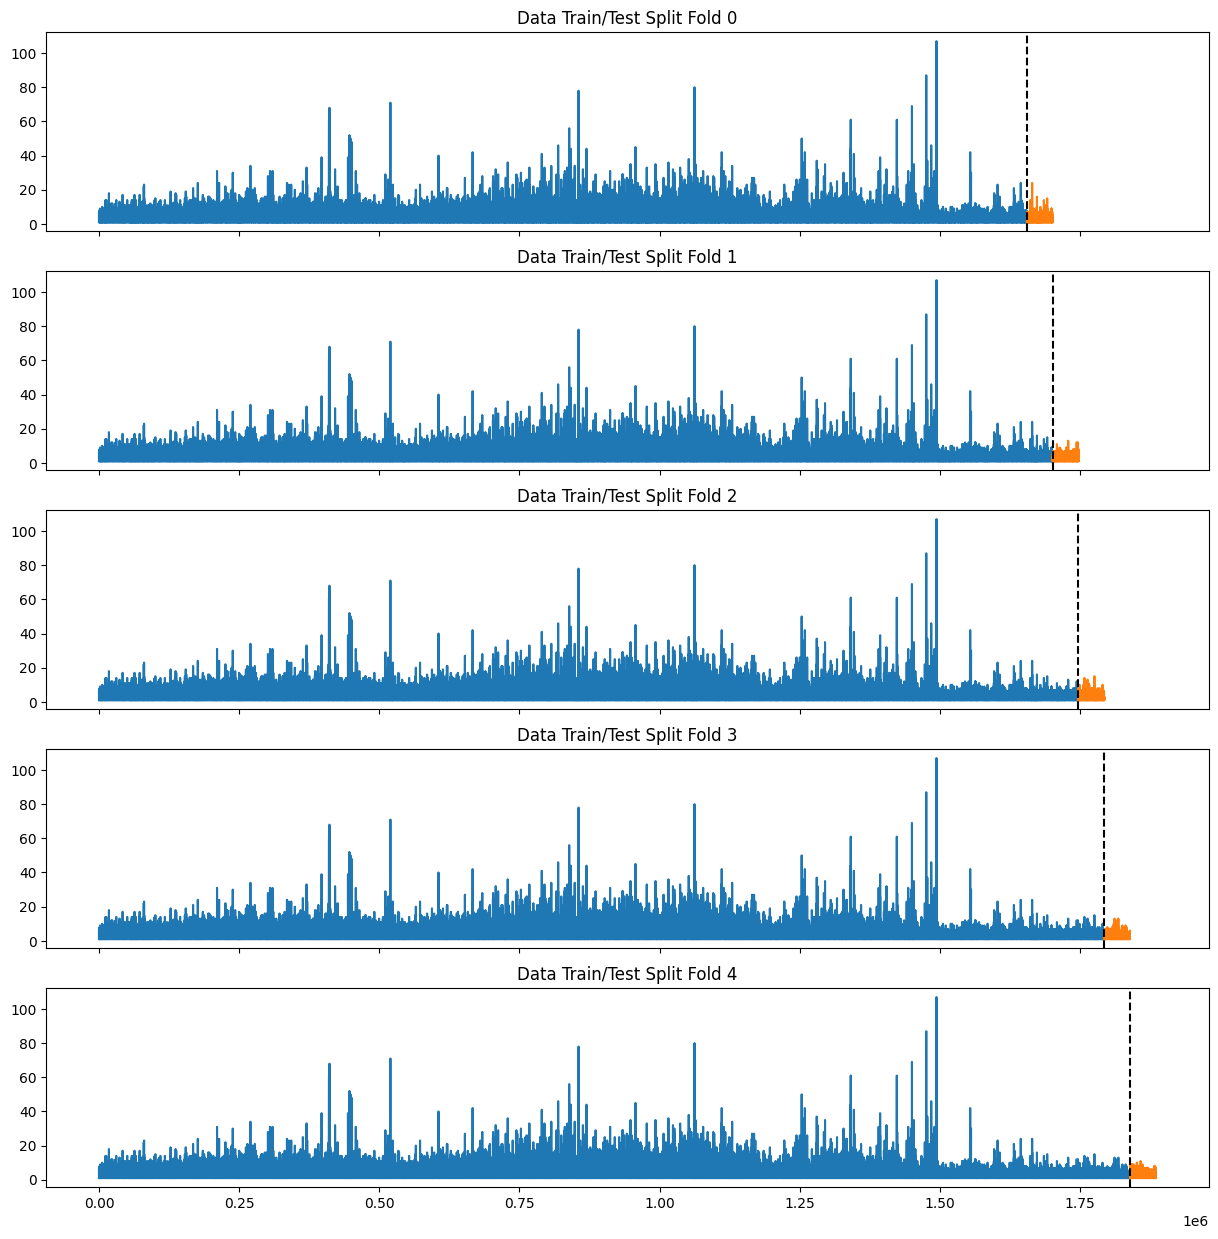

In [5]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*5*df['start_station_name'].nunique(), gap=24)
df = df.sort_index()

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['demand'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['demand'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [6]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*5*df['start_station_name'].nunique(), gap=24)
df = df.sort_index()

fold = 0
preds = pd.DataFrame()
rmse = []
mape = []
le = preprocessing.LabelEncoder()
scaler = MinMaxScaler(feature_range=(1, 2))
SCALER_FEATURES = ["start_time_year", "start_time_month", 
                   "start_time_day", "start_time_hour", 
                   "start_time_week", "start_time_quarter",
                   "start_time_dayofweek"]
target_scaler = MinMaxScaler(feature_range=(1, 2))
df[SCALER_FEATURES] = scaler.fit_transform(df[SCALER_FEATURES])
df[['demand']] = target_scaler.fit_transform(df[['demand']])
df['start_station_name'] = le.fit_transform(df['start_station_name'])
df['is_holiday'] = df['is_holiday'].astype(int)


In [7]:
24*10*df['start_station_name'].nunique()

91920

In [8]:

for train_idx, val_idx in tss.split(df):

    train = df.iloc[train_idx]
    test = df.iloc[val_idx]


    FEATURES = ["start_station_name", 
                "start_time_year",
                "start_time_month",
                "start_time_day",
                "start_time_hour",
                "start_time_week",
                "start_time_quarter",
                "start_time_dayofweek",
                "is_holiday",
                "clusters",
                "temp",
                "dwpt",
                "rhum",
                "prcp",
                "wdir",
                "wspd",
                "pres",
                "coco",
               
               ]
    TARGET = 'demand'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = RandomForestRegressor(random_state=42)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    preds_out = X_test.copy()
    preds_out['actual_demand'] = y_test
    preds_out['pred'] = y_pred
    preds = preds.append(preds_out)
    rmse_score = np.sqrt(mean_squared_error(y_test, y_pred))
    mape_score = mean_absolute_percentage_error(y_test, y_pred)
    rmse.append(rmse_score)
    mape.append(mape_score)
    print(rmse_score)
    print(mape_score)
    print(preds.head())
    print(preds.tail())
    
print(f"Mean RMSE: {np.mean(rmse)}")
print(f"Mean MAPE: {np.mean(mape)}")
del df
del X_train
del y_train
del X_test

0.007774492854664888
0.004905371370458468
         start_station_name  start_time_year  start_time_month  \
1655024                 218              2.0          1.727273   
1655025                 160              2.0          1.727273   
1655026                 210              2.0          1.727273   
1655027                 161              2.0          1.727273   
1655028                 363              2.0          1.727273   

         start_time_day  start_time_hour  start_time_week  start_time_quarter  \
1655024        1.166667         1.173913         1.673077            1.666667   
1655025        1.166667         1.173913         1.673077            1.666667   
1655026        1.166667         1.173913         1.673077            1.666667   
1655027        1.166667         1.173913         1.673077            1.666667   
1655028        1.166667         1.173913         1.673077            1.666667   

         start_time_dayofweek  is_holiday  actual_demand      pred  
16550

0.006399831284171166
0.004330276279945126
         start_station_name  start_time_year  start_time_month  \
1655024                 218              2.0          1.727273   
1655025                 160              2.0          1.727273   
1655026                 210              2.0          1.727273   
1655027                 161              2.0          1.727273   
1655028                 363              2.0          1.727273   

         start_time_day  start_time_hour  start_time_week  start_time_quarter  \
1655024        1.166667         1.173913         1.673077            1.666667   
1655025        1.166667         1.173913         1.673077            1.666667   
1655026        1.166667         1.173913         1.673077            1.666667   
1655027        1.166667         1.173913         1.673077            1.666667   
1655028        1.166667         1.173913         1.673077            1.666667   

         start_time_dayofweek  is_holiday  actual_demand      pred  
16550

In [9]:
suf = "_nov_2022_weather"

preds.to_csv(f"test_predictions{suf}.csv")
del preds

filename = f'demand_model{suf}.sav'
joblib.dump(reg, filename)
del reg

filename = f'target_scaler{suf}.sav'
joblib.dump(target_scaler, filename)
del target_scaler

filename = f'scaler{suf}.sav'
joblib.dump(scaler, filename)
del scaler

filename = f'label_encoder{suf}.sav'
joblib.dump(le, filename)
del le


NameError: name 'reg' is not defined

In [ ]:
y_test

In [ ]:
#preds['demand'] = preds['actual_demand']
#preds[SCALER_FEATURES] = scaler.inverse_transform(preds[SCALER_FEATURES])

In [ ]:
preds
